<a href="https://colab.research.google.com/github/ZahraShourmeij/Transformers/blob/master/Bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!wget -nc https://www.dropbox.com/scl/fi/354euga39eauii3ngp9u5/EXIST2021_training.tsv?rlkey=hjubyx1q7z8aizyx1hufnsi91&dl=0

File ‘EXIST2021_training.tsv?rlkey=hjubyx1q7z8aizyx1hufnsi91’ already there; not retrieving.



In [3]:
!pip install transformers

In [4]:
import pandas as pd
import numpy as np

import torch

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

In [5]:
df = pd.read_csv('EXIST2021_training.tsv?rlkey=hjubyx1q7z8aizyx1hufnsi91', sep="\t")

In [6]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6977 entries, 0 to 6976
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   test_case  6977 non-null   object
 1   id         6977 non-null   int64 
 2   source     6977 non-null   object
 3   language   6977 non-null   object
 4   text       6977 non-null   object
 5   task1      6977 non-null   object
 6   task2      6977 non-null   object
dtypes: int64(1), object(6)
memory usage: 381.7+ KB


In [7]:
df = df[['task1','text']]

In [8]:
df.head()

,task1,text
0,sexist,"She calls herself ""anti-feminazi"" how about sh..."
1,non-sexist,"Now, back to these women, the brave and the be..."
2,sexist,"@CurvyBandida @Xalynne_B Wow, your skirt is ve..."
3,non-sexist,@AurelieGuiboud Incredible! Beautiful!But I l...
4,non-sexist,i find it extremely hard to believe that kelly...


<Axes: >

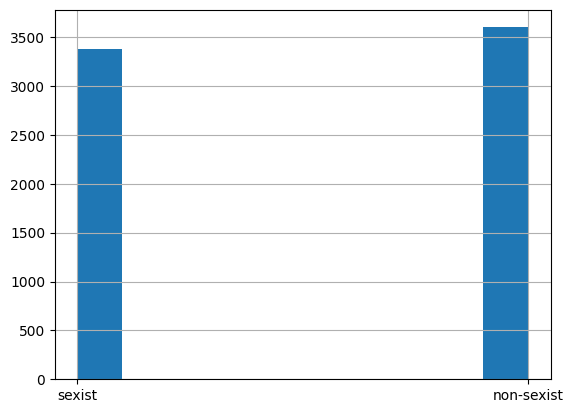

In [9]:
df['task1'].hist()

In [10]:
target_map = { 'sexist': 1, 'non-sexist': 0}
df['target'] = df['task1'].map(target_map)

In [11]:
df1 = df[['text','target']]
df1.columns = ['sentence','label']
df1.to_csv('data.csv', index = False)

In [12]:
!pip install datasets

In [13]:
from datasets import load_dataset
raw_dataset = load_dataset('csv', data_files = 'data.csv')

Generating train split: 0 examples [00:00, ? examples/s]

In [14]:
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 6977
    })
})

In [15]:
split = raw_dataset['train'].train_test_split(test_size=0.3, seed=42)

In [16]:
split

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 4883
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 2094
    })
})

In [17]:
# Import AutoTokenizer and create tokenizer object
from transformers import AutoTokenizer
checkpoint = 'bert-base-cased'
tokernizer = AutoTokenizer.from_pretrained(checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [18]:
#The “truncation” argument is set to “True”, which means that the tokenization function will truncate sequences that are longer than the maximum length specified by the model.
def tokenize_fn(batch):
  return tokernizer(batch['sentence'], truncation = True)

In [19]:
tokenized_dataset = split.map(tokenize_fn, batched = True)

Map:   0%|          | 0/4883 [00:00<?, ? examples/s]

Map:   0%|          | 0/2094 [00:00<?, ? examples/s]

In [20]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

In [21]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels = 2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
!pip install torchinfo

In [23]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                                  Param #
BertForSequenceClassification                           --
├─BertModel: 1-1                                        --
│    └─BertEmbeddings: 2-1                              --
│    │    └─Embedding: 3-1                              22,268,928
│    │    └─Embedding: 3-2                              393,216
│    │    └─Embedding: 3-3                              1,536
│    │    └─LayerNorm: 3-4                              1,536
│    │    └─Dropout: 3-5                                --
│    └─BertEncoder: 2-2                                 --
│    │    └─ModuleList: 3-6                             85,054,464
│    └─BertPooler: 2-3                                  --
│    │    └─Linear: 3-7                                 590,592
│    │    └─Tanh: 3-8                                   --
├─Dropout: 1-2                                          --
├─Linear: 1-3                                           1,538
Total params: 10

In [24]:
pip install accelerate -U

In [25]:
training_args = TrainingArguments(output_dir='training_dir',
                                  evaluation_strategy='epoch',
                                  save_strategy='epoch',
                                  num_train_epochs=3,
                                  per_device_train_batch_size=16,
                                  per_device_eval_batch_size=64,
                                  )

In [26]:
def compute_metrics(logits_and_labels):
  logits, labels = logits_and_labels
  predictions = np.argmax(logits, axis=-1)
  acc = np.mean(predictions == labels)
  f1 = f1_score(labels, predictions, average = 'micro')
  return {'accuracy': acc, 'f1_score': f1}

In [27]:
trainer = Trainer(model,
                  training_args,
                  train_dataset = tokenized_dataset["train"],
                  eval_dataset = tokenized_dataset["test"],
                  tokenizer=tokernizer,
                  compute_metrics=compute_metrics)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss


In [ ]:
! ls training_dir

In [ ]:
from transformers import pipeline

In [ ]:
saved_model = pipeline('text-classification',
                       model = 'training_dir/checkpoint-1282')

In [ ]:
split['test']

In [ ]:
prediction = saved_model(split['test']['sentence'])

In [ ]:
prediction[:10]

In [ ]:
def get_label(d):
  return int(d['label'].split('_')[1])
predictions = [get_label(d) for d in prediction]

In [ ]:
print("acc:",accuracy_score(split['test']['label'], predictions))

In [ ]:
print("f1:",f1_score(split['test']['label'], predictions, average = 'macro'))

In [ ]:
# create function for plotting confusion matrix
def plot_cm(cm):
  classes = ['negative','positive','neutral']
  df_cm = pd.DataFrame(cm, index=classes, columns=classes)
  ax = sns.heatmap(df_cm, annot = True, fmt='g')
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Actual')

cm = confusion_matrix(split['test']['label'],predictions, normalize = 'true')
plot_cm(cm)
